In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [4]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/mu/MU_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


        Price   Open  Close   High      Volume
0      Ticker     MU     MU     MU          MU
1        Date    NaN    NaN    NaN         NaN
2  2020-06-09  51.42  51.91  52.25  17840800.0
3  2020-06-08  53.23  52.44  53.36  22850600.0
4  2020-06-05  51.43  52.46  53.54  34110700.0


In [5]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Price     0
Open      1
Close     1
High      1
Volume    1
dtype: int64
             Price  Open Close  High      Volume
count         2301  2300  2300  2300        2300
unique        2301  1732  1715  1719        2297
top     2011-04-20  5.49   5.7  5.66  19337500.0
freq             1     7     7     8           2


In [7]:
import pandas as pd

# Step 1: Skip the first two junk rows and create a clean copy
data_cleaned = data.iloc[2:].copy()

# Step 2: Rename the 'Price' column to 'Date'
data_cleaned.rename(columns={'Price': 'Date'}, inplace=True)

# Step 3: Convert the 'Date' column to a proper datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Now, you can sort by the 'Date' column without an error
data_cleaned = data_cleaned.sort_values(by='Date', ascending=True)

# Optional: Convert other columns to numeric if needed
for col in ['Open', 'Close', 'High', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Display the head of the cleaned and sorted DataFrame
print(data_cleaned.head())

           Date   Open  Close   High      Volume
2300 2011-04-20  10.64  11.12  11.14  52613700.0
2299 2011-04-21  11.20  11.25  11.44  43506100.0
2298 2011-04-25  11.19  11.06  11.22  20447100.0
2297 2011-04-26  11.09  11.33  11.37  27400000.0
2296 2011-04-27  11.32  11.52  11.55  29748500.0


In [9]:
import pandas as pd

# --- FIX: Convert columns to a numeric type before calculations ---
# Use errors='coerce' to turn any non-numeric values into NaN (Not a Number)
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day's features
data['Movement'] = data['Movement'].shift(1)

# Drop rows with NaN values that were created during calculations
data = data.dropna(subset=['Movement'])

# Convert Movement into a binary target variable (1 for up, 0 for down/flat)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print("Distribution of the 'Movement' target variable:")
print(data['Movement'].value_counts().sort_index())

Distribution of the 'Movement' target variable:
Movement
0    1193
1    1105
Name: count, dtype: int64


/tmp/ipython-input-89519153.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Movement'] = (data['Movement'] > 0).astype(int)


In [11]:
# If you filtered your data, add .copy() at the end
# Example: data = original_df[original_df['some_condition']].copy()

# Or, if you are working on a cleaned dataframe, ensure it's a copy
# For example, from our previous steps:
data_cleaned = data.iloc[2:].copy() # The .copy() here is key

# --- Now, your calculations will not raise a warning ---

# Calculate daily returns (in percentage)
data_cleaned['Daily_Return'] = data_cleaned['Close'].pct_change() * 100

# Choose a rolling window (e.g., 5 days) for volatility
window_size = 5
data_cleaned['Volatility'] = data_cleaned['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data_cleaned = data_cleaned.dropna(subset=['Volatility'])

# Display the result
print(data_cleaned.head())

         Price   Open  Close   High      Volume  Movement  Daily_Return  \
15  2020-05-20  45.42  45.55  45.94  17876500.0         1      3.147645   
16  2020-05-19  44.71  44.06  45.15  17389500.0         0     -3.271131   
17  2020-05-18  44.76  44.85  45.07  20307800.0         1      1.793010   
18  2020-05-15  42.27  43.37  43.73  28803900.0         0     -3.299889   
19  2020-05-14  42.05  44.66  44.71  27543500.0         0      2.974406   

    Volatility  
15    5.222790  
16    3.984955  
17    2.631294  
18    2.953152  
19    3.286256  


In [12]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [13]:
data.tail(20)


,Price,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2281,2011-05-18,9.79,9.82,9.86,37498700.0,0,-1.107754,1.547995,9.93,9.97,34770900.0,1.741803,1.818344
2282,2011-05-17,10.17,9.70,10.24,74861800.0,1,-1.221996,1.815673,9.82,9.86,37498700.0,-1.107754,1.547995
2283,2011-05-16,10.13,10.30,10.61,38662500.0,1,6.185567,3.086849,9.70,10.24,74861800.0,-1.221996,1.815673
2284,2011-05-13,10.41,10.15,10.42,30547500.0,1,-1.456311,3.267501,10.30,10.61,38662500.0,6.185567,3.086849
2285,2011-05-12,10.14,10.41,10.47,30700000.0,0,2.561576,3.344461,10.15,10.42,30547500.0,-1.456311,3.267501
2286,2011-05-11,10.44,10.16,10.67,40700000.0,1,-2.401537,3.588683,10.41,10.47,30700000.0,2.561576,3.344461
2287,2011-05-10,10.25,10.38,10.46,24391600.0,1,2.165354,3.444063,10.16,10.67,40700000.0,-2.401537,3.588683
2288,2011-05-09,10.56,10.21,10.6,49677000.0,1,-1.637765,2.329311,10.38,10.46,24391600.0,2.165354,3.444063
2289,2011-05-06,10.84,10.61,10.87,22662600.0,1,3.917728,2.775194,10.21,10.6,49677000.0,-1.637765,2.329311
2290,2011-05-05,10.42,10.65,10.81,35304000.0,0,0.377003,2.619976,10.61,10.87,22662600.0,3.917728,2.775194


In [14]:
# Rename the 'Price' column to 'Date'
data.rename(columns={'Price': 'Date'}, inplace=True)

# Verify the change by printing the columns again
print(data.columns)

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')


In [15]:
data.tail(20)

,Date,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2281,2011-05-18,9.79,9.82,9.86,37498700.0,0,-1.107754,1.547995,9.93,9.97,34770900.0,1.741803,1.818344
2282,2011-05-17,10.17,9.70,10.24,74861800.0,1,-1.221996,1.815673,9.82,9.86,37498700.0,-1.107754,1.547995
2283,2011-05-16,10.13,10.30,10.61,38662500.0,1,6.185567,3.086849,9.70,10.24,74861800.0,-1.221996,1.815673
2284,2011-05-13,10.41,10.15,10.42,30547500.0,1,-1.456311,3.267501,10.30,10.61,38662500.0,6.185567,3.086849
2285,2011-05-12,10.14,10.41,10.47,30700000.0,0,2.561576,3.344461,10.15,10.42,30547500.0,-1.456311,3.267501
2286,2011-05-11,10.44,10.16,10.67,40700000.0,1,-2.401537,3.588683,10.41,10.47,30700000.0,2.561576,3.344461
2287,2011-05-10,10.25,10.38,10.46,24391600.0,1,2.165354,3.444063,10.16,10.67,40700000.0,-2.401537,3.588683
2288,2011-05-09,10.56,10.21,10.6,49677000.0,1,-1.637765,2.329311,10.38,10.46,24391600.0,2.165354,3.444063
2289,2011-05-06,10.84,10.61,10.87,22662600.0,1,3.917728,2.775194,10.21,10.6,49677000.0,-1.637765,2.329311
2290,2011-05-05,10.42,10.65,10.81,35304000.0,0,0.377003,2.619976,10.61,10.87,22662600.0,3.917728,2.775194


In [16]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [17]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.010737
Close_lag1          -0.035732
High_lag1           -0.025897
Volume_lag1          0.017285
Daily_Return_lag1    0.026605
Volatility_lag1      0.091929
Name: Movement, dtype: float64


In [18]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


     Open  Close_lag1 High_lag1 Volume_lag1  Daily_Return_lag1  \
9   45.53       45.26     46.55  21809100.0          -1.006124   
10  47.56       46.79      46.9  26337000.0           3.380468   
11  44.87       45.38     47.65  38289300.0          -3.013464   
12  45.14       48.29     48.42  56071500.0           6.412517   
13  44.09       44.73      45.6  24303900.0          -7.372127   

    Volatility_lag1  
9          2.223016  
10         3.472126  
11         3.255123  
12         4.494500  
13         5.396255  
9     1
10    1
11    0
12    0
13    0
Name: Movement, dtype: int64


In [19]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-05-04', '2011-05-03', '2011-05-02', '2011-04-29',
               '2011-04-28', '2011-04-27', '2011-04-26', '2011-04-25',
               '2011-04-21', '2011-04-20'],
              dtype='datetime64[ns]', name='Date', length=2292, freq=None)


In [20]:
X.index = data.index
print(X.index)

DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-05-04', '2011-05-03', '2011-05-02', '2011-04-29',
               '2011-04-28', '2011-04-27', '2011-04-26', '2011-04-25',
               '2011-04-21', '2011-04-20'],
              dtype='datetime64[ns]', name='Date', length=2292, freq=None)


In [21]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-11-20 to 2020-05-29
Test Dates: 2017-05-17 to 2018-11-19
--------------------------------------------------
Fold 2:
Train Dates: 2017-05-17 to 2020-05-29
Test Dates: 2015-11-09 to 2017-05-16
--------------------------------------------------
Fold 3:
Train Dates: 2015-11-09 to 2020-05-29
Test Dates: 2014-05-06 to 2015-11-06
--------------------------------------------------
Fold 4:
Train Dates: 2014-05-06 to 2020-05-29
Test Dates: 2012-10-24 to 2014-05-05
--------------------------------------------------
Fold 5:
Train Dates: 2012-10-24 to 2020-05-29
Test Dates: 2011-04-20 to 2012-10-23
--------------------------------------------------


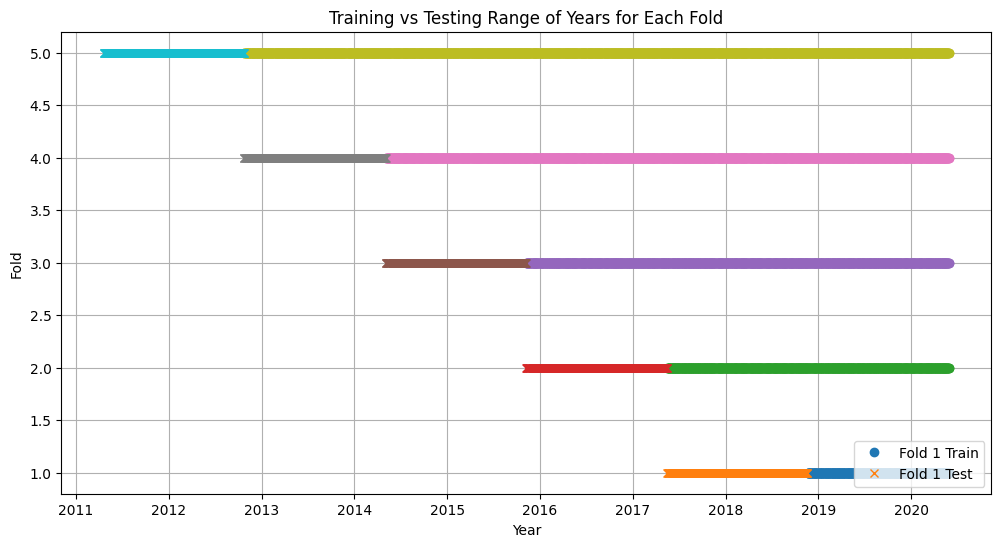

In [22]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[187  21]
 [  5 169]]


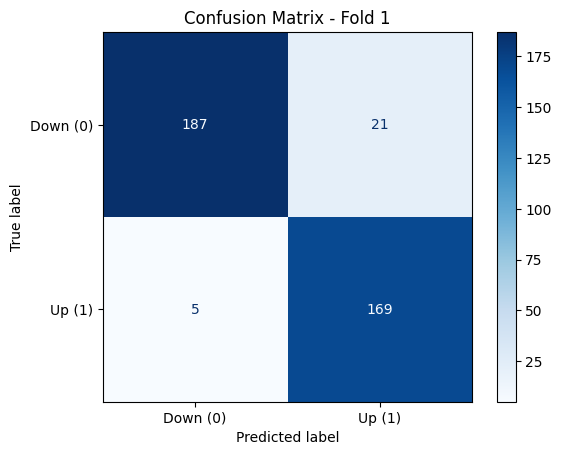

Fold 1 Accuracy: 0.93
--------------------------------------------------

Fold 2 Confusion Matrix:
[[172  27]
 [  4 179]]


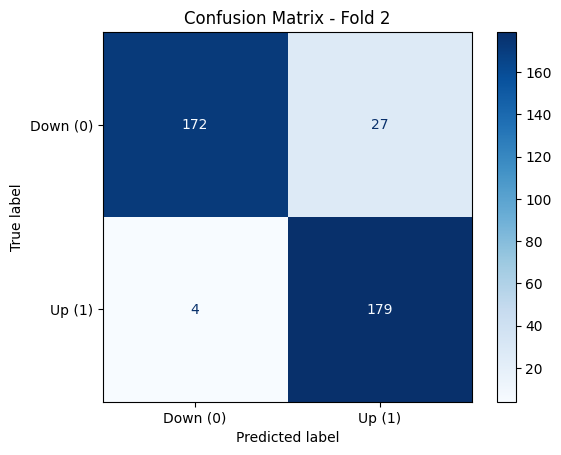

Fold 2 Accuracy: 0.92
--------------------------------------------------

Fold 3 Confusion Matrix:
[[177   7]
 [ 20 178]]


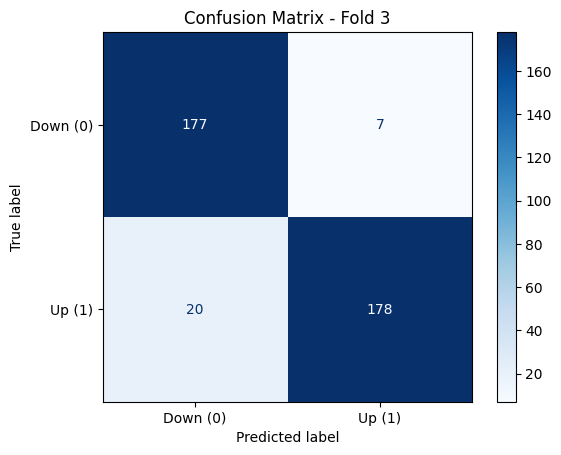

Fold 3 Accuracy: 0.93
--------------------------------------------------

Fold 4 Confusion Matrix:
[[209  24]
 [ 13 136]]


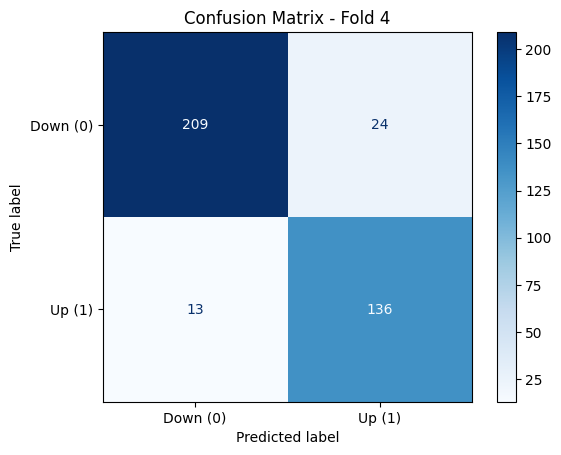

Fold 4 Accuracy: 0.90
--------------------------------------------------

Fold 5 Confusion Matrix:
[[153  17]
 [ 83 129]]


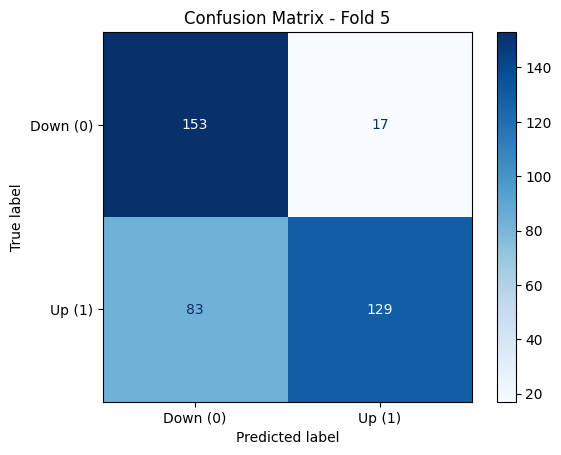

Fold 5 Accuracy: 0.74
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.88
Precision: 0.89
Recall: 0.87
F1-Score: 0.88
ROC-AUC: 0.97


In [23]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 - Balanced Class Distribution:
Movement
0    187
1    187
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[186  22]
 [  4 170]]


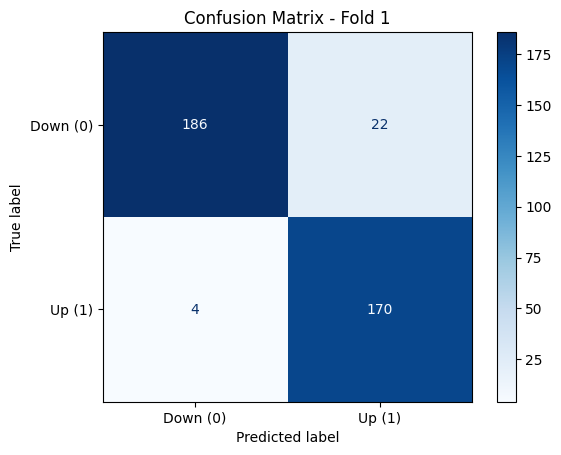

Fold 1 Accuracy: 0.93
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    361
1    361
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[153  46]
 [  0 183]]


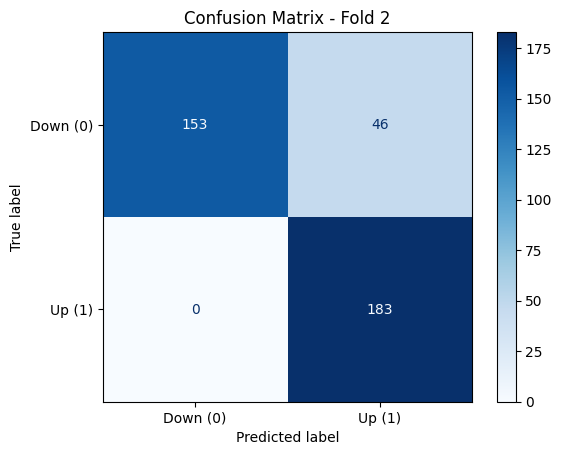

Fold 2 Accuracy: 0.88
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    544
1    544
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[167  17]
 [  9 189]]


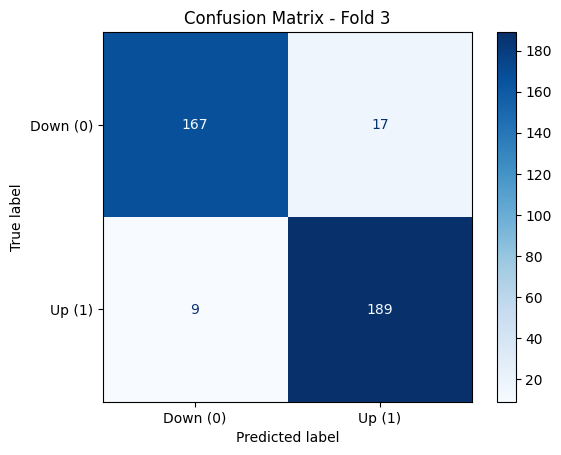

Fold 3 Accuracy: 0.93
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    742
1    742
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[196  37]
 [  8 141]]


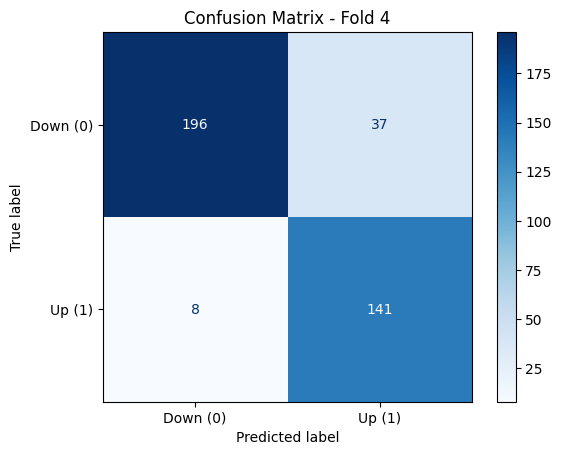

Fold 4 Accuracy: 0.88
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    891
1    891
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[141  29]
 [ 47 165]]


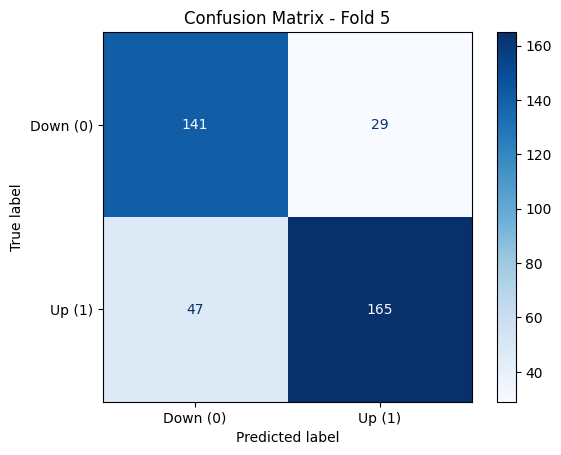

Fold 5 Accuracy: 0.80
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.89
Precision: 0.85
Recall: 0.93
F1-Score: 0.89
ROC-AUC: 0.96


In [24]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [25]:
data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/mu/MU_numerical_LR.csv')